In [357]:
###predict CI candidate, make pipeline  xgboost, logistic reg, knn, sgn,    -random forest? Tuesday at 4
import sklearn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
import missingno as msno
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# WUSM_df=pd.read_excel(r"/Users/williambray/Data/CI_Candidacy_List_merge(8).xlsx")
# Old_df=pd.read_excel(r"/Users/williambray/Data/Old_CI_merge(5).xlsx")
# Merged_df=pd.concat([Old_df,WUSM_df],axis=0)

#cole impute merged from old and wusm
Merged_df_imputed=pd.read_excel(r"/Users/williambray/Downloads/merged_audioimputed_Will.xlsx")
#new ci registry
df_new=pd.read_excel(r"/Users/williambray/Data/Cole_New_Candidacy_clean(4).xlsx")
#merge
Merged_all=pd.concat([Merged_df_imputed,df_new],axis=0)
Merged_df_final=prepare_dataset(Merged_all)



###Patient Data yrs since no HA use imputed with HAcur==0=0
###HAyrs imputed with patient data r/l hearing aid use==No=0



#No HA use yrs= never bias introduced, should fill in blanks if No HA use?
#DNT for AzBio 10 could be filled as 0 if AzBio quiet is 0? is that imputation already written

/var/folders/98/1tsk1jcx4vv6x21fv06tr0j40000gn/T/ipykernel_16736/1413111327.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['AzBio10SNR_bi']<=60)&(df['AzBioQuiet_bi']<= 60),'CI candidate']=True
/var/folders/98/1tsk1jcx4vv6x21fv06tr0j40000gn/T/ipykernel_16736/1413111327.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['CNC_L']<=40)&(df['CNC_R']<= 40),'CNC candidate']=True


In [355]:
Merged_df_final.to_excel('Cleaned_All_CI_Merged_keep_cols_imputed_(1).xlsx', index=True)

In [319]:
def prepare_dataset(df):
    df=HearingAidUse(df)
    df=select_cols(df)
    df=binary_classification(df)
    df=impute_PTA(df)
    df=Age_of_onset(df)
    df=fill_na_prior_surg(df)
#    df=remove_empty_col(df)
    df=drop_peds(df)
    df=fix_Age_onset(df)
    df=fix_no_HA_use(df)
    df=binary_PriorES(df)
    df=clean_categories(df)
    df=remove_99(df)
    #df=cand_fix_CNC(df)
    df=cleaning(df)
    return df

In [359]:
Merged_df_final['HAyrs_L'].unique()

array([ 0.  ,   nan,  1.  ,  0.1 , 18.  ,  2.  ,  0.5 ,  4.  ,  3.  ,
        5.  ,  6.  , 10.  , 40.  , 22.  ,  9.  , 15.  , 54.  , 12.  ,
       36.  , 56.  ,  8.  , 30.  , 50.  , 14.  ,  7.  , 20.  , 13.  ,
       25.  , 29.  , 26.  , 19.  , 31.  , 23.  ,  0.25, 11.  , 41.  ,
       67.  , 35.  , 28.  , 57.  , 24.  , 38.  , 74.  , 42.  ,  1.5 ,
        2.5 , 60.  , 45.  , 55.  ,  7.5 , 16.  , 17.  , 53.  , 33.  ,
       59.  , 58.  , 61.  , 69.  ,  0.33, 49.  ,  0.17])

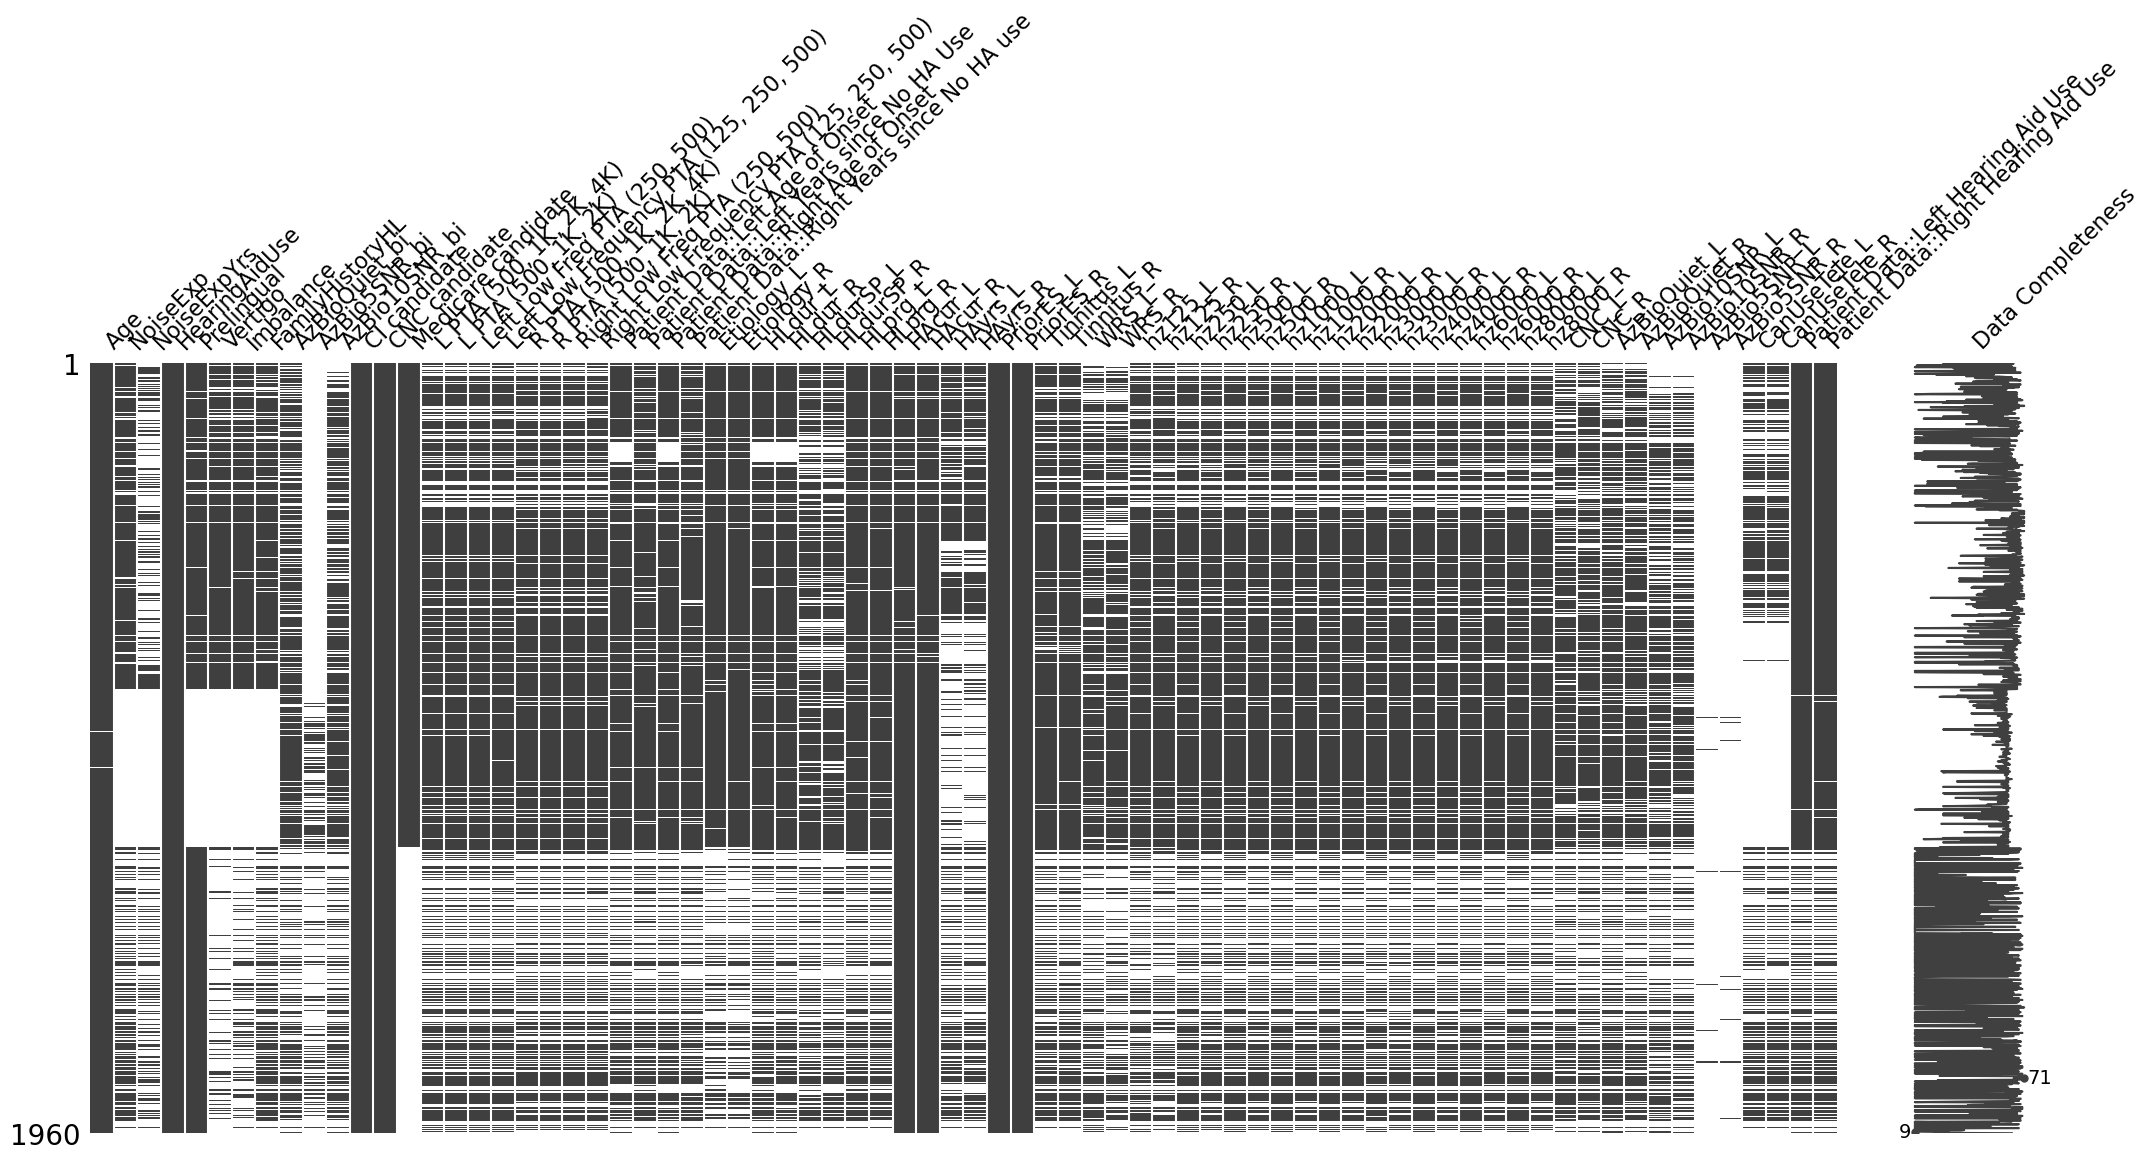

In [358]:
msno.matrix(Merged_df_final,labels=True)
plt.show()

In [321]:
def remove_99(df):
    df.loc[df['Etiology_L']==99,'Etiology_L']='Unknown'
    df.loc[df['Etiology_R']==99,'Etiology_R']='Unknown'
    df.loc[df['HLprg_L']==99,'HLprg_L']='Unknown'
    df.loc[df['HLprg_R']==99,'HLprg_R']='Unknown'
    return df
def cand_fix_az(df):
    df['CI candidate']= (df['AzBio10SNR_bi']<=60)| (df['AzBioQuiet_bi'] <= 60)
    #df = df.dropna(subset=['AzBioQuiet_bi', 'AzBio10SNR_bi'], how='all')
    binary_dict={'Yes':1, 'No':0, True:1,False:0}
    df['CI candidate']=df['CI candidate'].replace(binary_dict)
    #df['CNC candidate']=df['CNC candidate'].replace(binary_dict)
    return df
def cand_fix_CNC(df):
    df['CNC candidate']= (df['CNC_L']<=40)| (df['CNC_R'] <=40)
    #df = df.dropna(subset=['CNC_L', 'CNC_R'], how='all')
    binary_dict={'Yes':1, 'No':0, True:1,False:0}
    df['CNC candidate']=df['CNC candidate'].replace(binary_dict)
    return df
Merged_df_final['CNC candidate'].describe()

count    1232.000000
mean        0.198052
std         0.398693
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: CNC candidate, dtype: float64

In [356]:
cat_col_more=[
    'Etiology_L',
    'Etiology_R',
    'HLprg_L',
    'HLprg_R'
]
num_col_more=[
    'Age',
    'NoiseExpYrs',
 #   'CNC_bi',#100
 #####wordscore   'AzBioQuiet_bi',#100
 #   'AzBio5SNR_bi',#100
 #####wordscore    'AzBio10SNR_bi',
   # 'MOCA',
    'L PTA (500, 1K, 2K, 4K)',#125
    'L PTA (500, 1K, 2K)',#125
    'Left Low Freq PTA (250, 500)',#125
    'Left Low Frequency PTA (125, 250, 500)',#125
    'R PTA (500, 1K, 2K, 4K)',#125
    'R PTA (500, 1K, 2K)',#125
    'Right Low Freq PTA (250, 500)',#125
    'Right Low Frequency PTA (125, 250, 500)',#125
    'Patient Data::Left Age of Onset',#
    'Patient Data::Left Years since No HA Use',#
    'Patient Data::Right Age of Onset',#
    'Patient Data::Right Years since No HA use',
    'HLdur_L',#
    'HLdur_R',#
    'HLdurSP_L',#
    'HLdurSP_R',#
    'HAyrs_L',#  deal with -0.1 value, ask Dr. Shew
    'HAyrs_R',
    'WRS_L',#
    'WRS_R',#
    'hz125_L',#125
    'hz125_R',
    'hz250_L',
    'hz250_R',
    'hz500_L',
    'hz500_R',
    'hz1000_L',
    'hz1000_R',
    'hz2000_L',
    'hz2000_R',
    'hz3000_L',
    'hz3000_R',
    'hz4000_L',
    'hz4000_R',
    'hz6000_L',
    'hz6000_R',
    'hz8000_L',
    'hz8000_R',
 #####wordscore    'CNC_L',#100
  #####wordscore   'CNC_R',#100
  #####wordscore   'AzBioQuiet_L',#100
   #####wordscore  'AzBioQuiet_R',#100
   #####wordscore  'AzBio10SNR_L',#100
   #####wordscore  'AzBio10SNR_R',#100
 #   'AzBio5SNR_L',#100
 #   'AzBio5SNR_R',
]
binary_col_more=[
    'NoiseExp',
 #   'NoiseExpYrs',
    'HearingAidUse',
    'Prelingual',
    'Vertigo',
    'Imbalance',
    'FamilyHistoryHL',
    'HAcur_L',
    'HAcur_R',
    'Tinnitus_L',
    'Tinnitus_R',
    'CanUseTele_L',
    'CanUseTele_R',
    'Patient Data::Left Hearing Aid Use',
    'Patient Data::Right Hearing Aid Use',
    'PriorES_L',
    'PriorES_R'
    ]

replace={-0.1,0}
def cleaning(df):
    for col in num_col_more:
        df[col]=df[col].replace(99,np.nan)
    for col in binary_col_more:
        df[col]=df[col].replace(99,np.nan)
    df['HLprg_L']=df['HLprg_L'].replace('Progressive/Gradual','Gradual')
    df['HLprg_R']=df['HLprg_R'].replace('Progressive/Gradual','Gradual')
    df['HLprg_L']=df['HLprg_L'].replace('Progressive / Gradual','Gradual')
    df['HLprg_R']=df['HLprg_R'].replace('Progressive / Gradual','Gradual')
    df.loc[(df['AzBio10SNR_bi']<=60)&(df['AzBioQuiet_bi']<= 60),'CI candidate']=True
    df.loc[(df['AzBio10SNR_bi']>60)&(df['AzBioQuiet_bi'] > 60),'CI candidate']=False
    df.loc[(df['CNC_L']<=40)&(df['CNC_R']<= 40),'CNC candidate']=True
    df.loc[(df['CNC_L']>40)&(df['CNC_R']>40),'CNC candidate']=False
    df['CNC candidate']=(df['CNC_L']<=40)|(df['CNC_R']<=40)
    binary_dict={'Yes':1, 'No':0, True:1,False:0}
    df['CI candidate']=df['CI candidate'].replace(binary_dict)
    df['CNC candidate']=df['CNC candidate'].replace(binary_dict)
    
    df['HAyrs_L']=df['HAyrs_L'].replace(-0.1,0)
    df['HAyrs_R']=df['HAyrs_R'].replace(-0.1,0)
    return df

In [360]:
Merged_df_final['Etiology_L'].unique()

array(['Hereditary', 'NoiseExposure', nan, 'Unknown', 'Infection',
       'Menieres', 'Autoimmune', 'Congenital', 'Tumor', 'Trauma',
       'Otosclerosis', 'SSNHL', 'Iatrogenic', 'Acoustic Neuroma',
       'Presbycusis', 'Meningitis', 'Other', 'Noise Exposure',
       'Congenital Progressive', 'Genetic',
       'Ototoxic Medication / Radiation', 'Sudden Hearing Loss',
       "Meniere's Disease", 'Syndrome', 'Acoustic Trauma', 'Radiation',
       'Congenital Prematurity', 'Presbycusis\nNoise Exposure',
       'Noise Exposure\nPresbycusis',
       'Congenital\nCongenital Progressive', 'Other\nCongenital',
       'Temporal Bone Trauma',
       'Noise Exposure\nOtotoxic Medication / Radiation',
       'Genetic\nSudden Hearing Loss', 'Sudden Hearing Loss\nPresbycusis',
       'Noise Exposure\nOther', 'Otosclerosis\nGenetic',
       'Genetic\nRadiation',
       'Presbycusis\nAcoustic Trauma\nOther\nNoise Exposure',
       'Sudden Hearing Loss\nNoise Exposure', 'Noise Exposure\nGenetic',
    

# Select Columns

In [112]:
def select_cols(df): #=feature scaling ##=binary ###=categories
    cols=[ 
    'Age',#feature scaling
    'NoiseExp',##
    'NoiseExpYrs',#
    'HearingAidUse',##
    'Prelingual',##
    'Vertigo',##
    'Imbalance',##
    'FamilyHistoryHL',##
#    'CNC_bi',#100
    'AzBioQuiet_bi',#100
    'AzBio5SNR_bi',#100
    'AzBio10SNR_bi',#100
#    'MOCA',#30
    #'SSDCandidate',######################can remove col, all No. Might be smart to screen audiogram and CNC/AzBio for SSD as well
    'CI candidate',##--dependent var?
    'CNC candidate',##--dependent var?
    'Medicare candidate',##--dependent var?
    'L PTA (500, 1K, 2K, 4K)',#125
    'L PTA (500, 1K, 2K)',#125
    'Left Low Freq PTA (250, 500)',#125
    'Left Low Frequency PTA (125, 250, 500)',#125
    'R PTA (500, 1K, 2K, 4K)',#125
    'R PTA (500, 1K, 2K)',#125
    'Right Low Freq PTA (250, 500)',#125
    'Right Low Frequency PTA (125, 250, 500)',#125
    'Patient Data::Left Age of Onset',#
    'Patient Data::Left Years since No HA Use',#
    'Patient Data::Right Age of Onset',#
    'Patient Data::Right Years since No HA use',#
    'Etiology_L',### convert NotKnown to 99 (unknown category) run in each, create categories (take from other)
    'Etiology_R',### convert NotKnown to 99 (unknown category) run in each, create categories (take from other)
    'HLdur_L',#
    'HLdur_R',#
    'HLdurSP_L',#
    'HLdurSP_R',#
    'HLprg_L',### 6 categories
    'HLprg_R',### 6 categories
    'HAcur_L',##
    'HAcur_R',##
    'HAyrs_L',#  deal with -0.1 value, ask Dr. Shew
    'HAyrs_R',#  deal with -0.1 value, ask Dr. Shew
    'PriorES_L',############binary for Old, categorical for New and WUSM, could convert all to binary, impute missing as None (not sure why didnt carry over)
    'PriorES_R',############binary for Old, categorical for New and WUSM, could convert all to binary, same
    'Tinnitus_L',##
    'Tinnitus_R',##
    'WRS_L',#
    'WRS_R',#
    'hz125_L',#125
    'hz125_R',
    'hz250_L',
    'hz250_R',
    'hz500_L',
    'hz500_R',
    'hz1000_L',
    'hz1000_R',
    'hz2000_L',
    'hz2000_R',
    'hz3000_L',
    'hz3000_R',
    'hz4000_L',
    'hz4000_R',
    'hz6000_L',
    'hz6000_R',
    'hz8000_L',
    'hz8000_R',
    'CNC_L',#100
    'CNC_R',#100
    'AzBioQuiet_L',#100
    'AzBioQuiet_R',#100
    'AzBio10SNR_L',#100
    'AzBio10SNR_R',#100
    'AzBio5SNR_L',#100
    'AzBio5SNR_R',#100
    'CanUseTele_L',##
    'CanUseTele_R',##
    'Patient Data::Left Hearing Aid Use',## convert true false y/n to 1,0
    'Patient Data::Right Hearing Aid Use' ## convert true false y/n to 1,0
    ]
    df=df[cols]
    return df



# Binary Classification

In [113]:
def binary_classification(df):
    binary_cols=[
    'NoiseExp',##change to binary
    'NoiseExpYrs',#
    'HearingAidUse',##
    'Prelingual',##
    'Vertigo',##
    'Imbalance',##
    'FamilyHistoryHL',##
    'HAcur_L',##
    'HAcur_R',##
    'Tinnitus_L',##
    'Tinnitus_R',##
    'CanUseTele_L',##
    'CanUseTele_R',##
    'Patient Data::Left Hearing Aid Use',## convert true false y/n to 1,0
    'Patient Data::Right Hearing Aid Use' ## convert true false y/n to 1,0
    ]
    binary_dict={'Yes':1, 'No':0, True:1,False:0}
    df=df.replace(binary_dict)
    return df
        

In [114]:
def binary_PriorES(df):
    replace_dict={
        'Other':1, 'Cochlear Implant':1,
       'Craniotomy for Acoustic Neuroma':1, 'Tympanomastoidectomy':1,
       'Osseointegrated Implant':1, 'Endolymphatic Shunt':1,
       'Stapedotomy / Stapedectomy':1, 'Tympanoplasty / Tymp OCR':1}
    df['PriorES_L']=df['PriorES_L'].replace(replace_dict)
    df['PriorES_R']=df['PriorES_R'].replace(replace_dict)
    df.loc[df['PriorES_L']!=1,"PriorES_L"]=0
    df.loc[df['PriorES_R']!=1,"PriorES_R"]=0
    return df
        

In [115]:
print(Merged_df_final['PriorES_L'].describe())

count     1960
unique       2
top          0
freq      1685
Name: PriorES_L, dtype: int64


# Imputations

In [116]:
def impute_PTA(df):
    df['L PTA (500, 1K, 2K, 4K)'] = df[['hz500_L', 'hz1000_L', 'hz2000_L','hz4000_L']].mean(axis=1,skipna=True)
    df['L PTA (500, 1K, 2K)']= df[['hz500_L', 'hz1000_L', 'hz2000_L']].mean(axis=1,skipna=True)
    df['Left Low Freq PTA (250, 500)']=df[['hz250_L','hz500_L']].mean(axis=1,skipna=True)
    df['Left Low Frequency PTA (125, 250, 500)']=df[['hz500_L', 'hz250_L', 'hz125_L']].mean(axis=1,skipna=True)
    df['R PTA (500, 1K, 2K, 4K)'] =  df[['hz500_R', 'hz1000_R', 'hz2000_R','hz4000_R']].mean(axis=1,skipna=True)
    df['R PTA (500, 1K, 2K)'] =  df[['hz500_R', 'hz1000_R', 'hz2000_R']].mean(axis=1,skipna=True)
    df['Right Low Freq PTA (250, 500)'] =  df[['hz500_R', 'hz250_R']].mean(axis=1,skipna=True)
    df['Right Low Frequency PTA (125, 250, 500)']=df[['hz125_R','hz500_R', 'hz250_R']].mean(axis=1,skipna=True)
    return df

In [117]:
def Age_of_onset(df):
    df['Patient Data::Right Age of Onset']=df['Age']-df['HLdur_R']  
    df['Patient Data::Left Age of Onset']=df['Age']-df['HLdur_R']
    return df

In [118]:
def fill_na_prior_surg(df):
    df['PriorES_R'].fillna('0',inplace=True)
    df['PriorES_L'].fillna('0',inplace=True)
    return df 

In [119]:
def HearingAidUse(df):
    df['HearingAidUse']=(df['HAyrs_L']>0) | (df['HAyrs_R']>0)
    df['HearingAidUse']= (df['HAcur_L']==1)|((df['HAcur_R']==1))
    return df

# Remove NA

In [120]:
def remove_empty_col(df):
    df.dropna(how='any', inplace=True)
    return df

In [121]:
cols=[ 
    'Age',#feature scaling
#blank CIML    'NoiseExp',##
###    'NoiseExpYrs',#
    'HearingAidUse',##
#blank CIML    'Prelingual',##
#blank CIML    'Vertigo',##
#blank CIML    'Imbalance',##
#blank CIML    'FamilyHistoryHL',##
#    'CNC_bi',#100
    'AzBioQuiet_bi',#100
#    'AzBio5SNR_bi',#100
    'AzBio10SNR_bi',#100
#    'MOCA',#30
    #'SSDCandidate',######################can remove col, all No. Might be smart to screen audiogram and CNC/AzBio for SSD as well
    'CI candidate',##--dependent var?
    'CNC candidate',##--dependent var?
    'Medicare candidate',##--dependent var?
    'L PTA (500, 1K, 2K, 4K)',#125
    'L PTA (500, 1K, 2K)',#125
    'Left Low Freq PTA (250, 500)',#125
    'Left Low Frequency PTA (125, 250, 500)',#125
    'R PTA (500, 1K, 2K, 4K)',#125
    'R PTA (500, 1K, 2K)',#125
    'Right Low Freq PTA (250, 500)',#125
    'Right Low Frequency PTA (125, 250, 500)',#125
    'Patient Data::Left Age of Onset',#
    'Patient Data::Left Years since No HA Use',#
    'Patient Data::Right Age of Onset',#
    'Patient Data::Right Years since No HA use',#
    'Etiology_L',### convert NotKnown to 99 (unknown category) run in each, create categories (take from other)
    'Etiology_R',### convert NotKnown to 99 (unknown category) run in each, create categories (take from other)
    'HLdur_L',#
    'HLdur_R',#
    'HLdurSP_L',#
    'HLdurSP_R',#
    'HLprg_L',### 6 categories
    'HLprg_R',### 6 categories
    'HAcur_L',##
    'HAcur_R',##
###    'HAyrs_L',#  deal with -0.1 value, ask Dr. Shew
###    'HAyrs_R',#  deal with -0.1 value, ask Dr. Shew
    'PriorES_L',############binary for Old, categorical for New and WUSM, could convert all to binary, impute missing as None (not sure why didnt carry over)
    'PriorES_R',############binary for Old, categorical for New and WUSM, could convert all to binary, same
    'Tinnitus_L',##
    'Tinnitus_R',##
    'WRS_L',#
    'WRS_R',#
    'hz125_L',#125
    'hz125_R',
    'hz250_L',
    'hz250_R',
    'hz500_L',
    'hz500_R',
    'hz1000_L',
    'hz1000_R',
    'hz2000_L',
    'hz2000_R',
    'hz3000_L',
    'hz3000_R',
    'hz4000_L',
    'hz4000_R',
    'hz6000_L',
    'hz6000_R',
    'hz8000_L',
    'hz8000_R',
    'CNC_L',#100
    'CNC_R',#100
    'AzBioQuiet_L',#100
    'AzBioQuiet_R',#100
    'AzBio10SNR_L',#100
    'AzBio10SNR_R',#100
#    'AzBio5SNR_L',#100
#    'AzBio5SNR_R',#100
###    'CanUseTele_L',##
###    'CanUseTele_R',##
    'Patient Data::Left Hearing Aid Use',## convert true false y/n to 1,0
    'Patient Data::Right Hearing Aid Use' ## convert true false y/n to 1,0
    ]
for col in cols:
    print(Merged_df_final[col].unique())

[73. 84. 78. 76. 68. 71. 67. 64. 43. 69. 60. 44. 86. 61. 21. 79. 53. 80.
 28. 66. 54. 24. 22. 62. 70. 72. 18. 42. 65. 36. 23. 33. 30. 32. 87. 77.
 88. 81. 85. 47. 90. 48. 63. 59. 82. 26. 58. 51. 19. 52. 75. 92. 74. 49.
 94. 45. 89. 57. 20. 83. 55. 25. 37. 34. 96. 56. 46. 93. 91. 35. 95. 31.
 40. 39. 50. 41. 29. 27. 99. 38.]
[0 1]
[ nan  40.  16.  26.  18.  10.  44.  30.  58.  41.  20.   0.  81.  57.
  53.  23.  22.  29.   2.  89.  51.  43.  33.  88.  39.   6.  21.  32.
  77.  92.  24.  19.  66.  28.  82.  47.   1.  78.  31.  75.  83.   4.
  62.  14.  76.  64.  80.  36.  79.  61.  15.  54.  17.  56.  35.   9.
  37.  59. 100.   3.  38.  60.  46.  65.  34.  84.  70.  90.  55.  91.
   5.  45.  96.  42.  87.  11.  72.  63.  68.  67.  13.  52.   7.  97.
  48.  27.  25.  73.  74.  50.  69.  71.  85.  93.  95.  49.  98.  12.
  86.   8.  99.  94.]
[  nan  22.    5.   56.   25.   36.   16.   28.    0.   32.   19.    9.
  23.   14.   27.   17.   49.   11.   38.    3.    2.   75.   42.   47.
  15.

In [122]:
Merged_df_final['PriorES_L'].describe()


count     1960
unique       2
top          0
freq      1685
Name: PriorES_L, dtype: int64

In [123]:
def drop_peds(df):
    df=df[df['Age']>=18]
    return df
def fix_Age_onset(df):
    fixdict={
        'Patient Data::Left Age of Onset':{-1:0,-2:0},
        'Patient Data::Right Age of Onset':{-1:0,-2:0}
    }
    for cols in fixdict:
        for repl in fixdict[cols]:
            df.loc[df[cols]==repl, cols] = fixdict[cols][repl]
    return df

In [124]:
def fix_no_HA_use(df):
    df['Patient Data::Right Years since No HA use']=df['Patient Data::Right Years since No HA use'].fillna(df['HLdurSP_R'])
    df['Patient Data::Left Years since No HA Use']=df['Patient Data::Left Years since No HA Use'].fillna(df['HLdurSP_R'])
    return df

# New CI cleaning

In [170]:
def clean_categories(df):
    cat_cols=['Vertigo', 'Imbalance']
    repl_dict={'Episodic Imbalance':1, 'Chronic Imbalance':1,'Episodic Vertigo':1, 'Constant Vertigo':1}
    for col in cat_cols:
         df[col]=df[col].replace(repl_dict)
    return df



In [175]:
Merged_df_final.columns.tolist()

['Age',
 'NoiseExp',
 'NoiseExpYrs',
 'HearingAidUse',
 'Prelingual',
 'Vertigo',
 'Imbalance',
 'FamilyHistoryHL',
 'AzBioQuiet_bi',
 'AzBio5SNR_bi',
 'AzBio10SNR_bi',
 'CI candidate',
 'CNC candidate',
 'Medicare candidate',
 'L PTA (500, 1K, 2K, 4K)',
 'L PTA (500, 1K, 2K)',
 'Left Low Freq PTA (250, 500)',
 'Left Low Frequency PTA (125, 250, 500)',
 'R PTA (500, 1K, 2K, 4K)',
 'R PTA (500, 1K, 2K)',
 'Right Low Freq PTA (250, 500)',
 'Right Low Frequency PTA (125, 250, 500)',
 'Patient Data::Left Age of Onset',
 'Patient Data::Left Years since No HA Use',
 'Patient Data::Right Age of Onset',
 'Patient Data::Right Years since No HA use',
 'HLdur_L',
 'HLdur_R',
 'HLdurSP_L',
 'HLdurSP_R',
 'HAcur_L',
 'HAcur_R',
 'HAyrs_L',
 'HAyrs_R',
 'PriorES_L',
 'PriorES_R',
 'Tinnitus_L',
 'Tinnitus_R',
 'WRS_L',
 'WRS_R',
 'hz125_L',
 'hz125_R',
 'hz250_L',
 'hz250_R',
 'hz500_L',
 'hz500_R',
 'hz1000_L',
 'hz1000_R',
 'hz2000_L',
 'hz2000_R',
 'hz3000_L',
 'hz3000_R',
 'hz4000_L',
 'hz4000_R

In [182]:
Merged_df_final['Etiology_L'].unique()

array(['Hereditary', 'NoiseExposure', nan, 99, 'Infection', 'Menieres',
       'Autoimmune', 'Congenital', 'Tumor', 'Trauma', 'Otosclerosis',
       'SSNHL', 'Iatrogenic', 'Acoustic Neuroma', 'Presbycusis',
       'Meningitis', 'Other', 'Noise Exposure', 'Congenital Progressive',
       'Genetic', 'Ototoxic Medication / Radiation',
       'Sudden Hearing Loss', "Meniere's Disease", 'Syndrome',
       'Acoustic Trauma', 'Radiation', 'Congenital Prematurity',
       'Presbycusis\nNoise Exposure', 'Noise Exposure\nPresbycusis',
       'Congenital\nCongenital Progressive', 'Other\nCongenital',
       'Temporal Bone Trauma',
       'Noise Exposure\nOtotoxic Medication / Radiation',
       'Genetic\nSudden Hearing Loss', 'Sudden Hearing Loss\nPresbycusis',
       'Noise Exposure\nOther', 'Otosclerosis\nGenetic',
       'Genetic\nRadiation',
       'Presbycusis\nAcoustic Trauma\nOther\nNoise Exposure',
       'Sudden Hearing Loss\nNoise Exposure', 'Noise Exposure\nGenetic',
       'Skull Base